In [8]:

from langchain_openai import ChatOpenAI

# Quickstart

In [11]:
model = ChatOpenAI(model='qwen-plus')

In [15]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage("Hi! I'm Bob")]).pretty_print()

================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [16]:
model.invoke([HumanMessage(content="What's my name?")]).pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information such as your name. Could you please provide more context or clarify your question?


In [17]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="Hi! I'm Bob"),
        AIMessage(content="Hello Bob! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
).pretty_print()

================================== Ai Message ==================================

Your name is Bob! How can I assist you further, Bob?


# Message persistence

In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define the (single) node in the graph
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

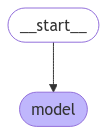

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable": {"thread_id": "abc123"}}

In [21]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today?


In [22]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob! How can I assist you further, Bob?


In [23]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information such as your name. Could you please provide more context or clarify your question?


In [24]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob! Is there something specific you'd like to know or discuss? 😊


# Prompt templates

In [35]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a funny gay. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [36]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

In [37]:
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [38]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello, Jim! Oh my, look at you just strolling in here like a fabulous vision! How can I help you today, darling? Need advice, or are you just here to spread your wonderfulness around? 😄


In [39]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Jim, sweetie! Didn't you just tell me that? You look like a Jim, walk like a Jim, and now you're asking if you're a Jim. Yes, you are indeed a Jim! Jim Jim Jim! 😄


In [42]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [46]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [47]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Bob."
language = "Chinese"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

你好！我是助手，很高兴认识你，鲍勃。有什么我可以帮你的吗？


In [48]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

你的名字是鲍勃。


# Managing Conversation History

In [53]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=5,
    strategy="last",
    token_counter=len,
    include_system=True,
    allow_partial=False,
    start_on="human",
    end_on=("human", "tool"),
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={})]

In [54]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [55]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have access to personal information unless you've shared it with me during our conversation. Could you let me know your name if you'd like me to use it?


In [56]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You didn't ask any specific math problem in our previous messages. If you have a math problem you'd like help with, feel free to ask!


# Streaming

In [58]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
        {"messages": input_messages, "language": language},
        config,
        stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|Hi| Todd|!| Here's a joke| for you:

Why| don't skeletons fight| each other?

Because| they don't have| the guts!||

In [60]:
config = {"configurable": {"thread_id": "abc790"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for event in app.stream(
        {"messages": input_messages, "language": language},
        config,
        stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi I'm Todd, please tell me a joke.
================================== Ai Message ==================================

Hi Todd! Here's a joke for you:

Why don't skeletons fight each other?

Because they don't have the guts!
